In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm import tqdm

In [3]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# 1. Определение трансформаций
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# 2. Загрузка данных
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) 
                          if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, -1  # -1 как фиктивная метка

# Загрузка train и test данных
train_dataset = datasets.ImageFolder('train', transform=train_transform)
test_dataset = TestDataset('test_upload', transform=test_transform)

# Определение количества классов
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Разделение train на train и validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Создание DataLoader'ов
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Number of classes: 10


In [6]:
# 3. Определение модели CNN
class CarCNN(nn.Module):
    def __init__(self, num_classes):
        super(CarCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
# 4. Функция для обучения
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, model_name='model'):
    best_f1 = 0.0
    train_losses = []
    val_losses = []
    val_f1_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Валидация
        val_loss, val_f1 = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {epoch_loss:.4f} - "
              f"Val loss: {val_loss:.4f} - "
              f"Val F1: {val_f1:.4f}")
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f'best_{model_name}.pth')
    
    return train_losses, val_losses, val_f1_scores

In [8]:
# 5. Функция для оценки
def evaluate_model(model, loader, criterion=None):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            if criterion and labels[0] != -1:  # Если есть метки и criterion передан
                labels = labels.to(device)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                all_labels.extend(labels.cpu().numpy())
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    
    if len(all_labels) > 0:
        val_loss = val_loss / len(loader.dataset)
        f1 = f1_score(all_labels, all_preds[:len(all_labels)], average='weighted')
        return val_loss, f1
    else:
        return None, all_preds

In [8]:
# 6. Обучение CNN модели
print("\nTraining CNN model...")
model_cnn = CarCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

cnn_train_losses, cnn_val_losses, cnn_val_f1 = train_model(
    model_cnn, train_loader, val_loader, criterion, optimizer, 
    num_epochs=10, model_name='cnn_model')


Training CNN model...


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 389/389 [24:42<00:00,  3.81s/it]


Epoch 1/10 - Train loss: 2.3033 - Val loss: 2.1881 - Val F1: 0.2044


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 389/389 [24:34<00:00,  3.79s/it]


Epoch 2/10 - Train loss: 2.0832 - Val loss: 1.9730 - Val F1: 0.2923


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 389/389 [25:21<00:00,  3.91s/it]


Epoch 3/10 - Train loss: 1.8385 - Val loss: 1.9688 - Val F1: 0.3232


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 389/389 [25:57<00:00,  4.00s/it]


Epoch 4/10 - Train loss: 1.6342 - Val loss: 1.6675 - Val F1: 0.4031


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 389/389 [24:59<00:00,  3.86s/it]


Epoch 5/10 - Train loss: 1.4450 - Val loss: 1.5006 - Val F1: 0.4856


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 389/389 [24:55<00:00,  3.85s/it]


Epoch 6/10 - Train loss: 1.2641 - Val loss: 1.3821 - Val F1: 0.5010


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 389/389 [25:54<00:00,  3.99s/it]


Epoch 7/10 - Train loss: 1.1119 - Val loss: 1.2567 - Val F1: 0.5548


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 389/389 [25:46<00:00,  3.98s/it]


Epoch 8/10 - Train loss: 0.9929 - Val loss: 1.0879 - Val F1: 0.6163


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 389/389 [24:40<00:00,  3.80s/it]


Epoch 9/10 - Train loss: 0.8934 - Val loss: 1.0776 - Val F1: 0.6116


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 389/389 [24:07<00:00,  3.72s/it]


Epoch 10/10 - Train loss: 0.8167 - Val loss: 0.9540 - Val F1: 0.6607


In [9]:
# 7. Обучение ResNet модели
print("\nTraining ResNet model...")
model_resnet = models.resnet18(pretrained=True)

# Замораживаем все слои, кроме последнего
for param in model_resnet.parameters():
    param.requires_grad = False

# Заменяем последний слой
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, num_classes)
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

# Обучение только последнего слоя
resnet_train_losses, resnet_val_losses, resnet_val_f1 = train_model(
    model_resnet, train_loader, val_loader, criterion, optimizer, 
    num_epochs=5, model_name='resnet_model')

# Fine-tuning всей модели
print("\nFine-tuning entire ResNet...")
for param in model_resnet.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001)

resnet_train_losses_ft, resnet_val_losses_ft, resnet_val_f1_ft = train_model(
    model_resnet, train_loader, val_loader, criterion, optimizer, 
    num_epochs=5, model_name='resnet_model_ft')


Training ResNet model...


D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 389/389 [05:34<00:00,  1.16it/s]


Epoch 1/5 - Train loss: 1.7443 - Val loss: 1.4473 - Val F1: 0.4885


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 389/389 [05:40<00:00,  1.14it/s]


Epoch 2/5 - Train loss: 1.3804 - Val loss: 1.2960 - Val F1: 0.5456


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 389/389 [05:40<00:00,  1.14it/s]


Epoch 3/5 - Train loss: 1.2710 - Val loss: 1.2366 - Val F1: 0.5590


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 389/389 [05:28<00:00,  1.18it/s]


Epoch 4/5 - Train loss: 1.2150 - Val loss: 1.1969 - Val F1: 0.5849


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 389/389 [05:29<00:00,  1.18it/s]


Epoch 5/5 - Train loss: 1.1887 - Val loss: 1.1233 - Val F1: 0.6031

Fine-tuning entire ResNet...


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 389/389 [15:40<00:00,  2.42s/it]


Epoch 1/5 - Train loss: 0.5575 - Val loss: 0.3558 - Val F1: 0.8794


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 389/389 [15:25<00:00,  2.38s/it]


Epoch 2/5 - Train loss: 0.2566 - Val loss: 0.2888 - Val F1: 0.8927


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 389/389 [15:42<00:00,  2.42s/it]


Epoch 3/5 - Train loss: 0.1669 - Val loss: 0.2959 - Val F1: 0.9046


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 389/389 [15:17<00:00,  2.36s/it]


Epoch 4/5 - Train loss: 0.1315 - Val loss: 0.2328 - Val F1: 0.9193


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 389/389 [15:20<00:00,  2.37s/it]


Epoch 5/5 - Train loss: 0.1119 - Val loss: 0.2449 - Val F1: 0.9164


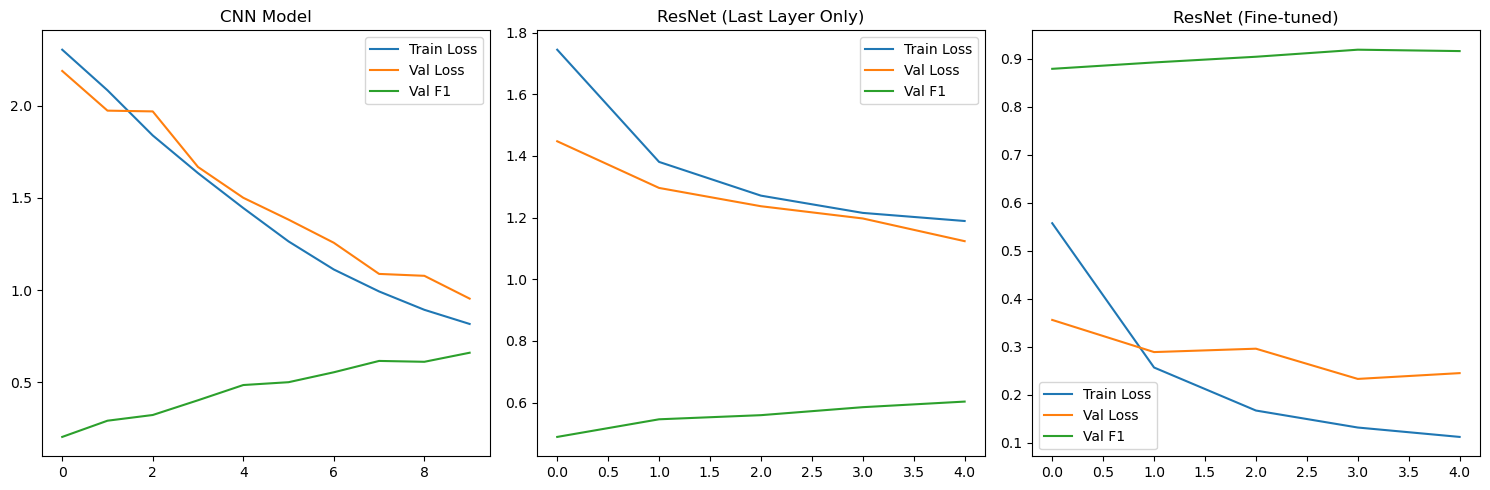

In [10]:
# 8. Визуализация результатов
plt.figure(figsize=(15, 5))

# CNN результаты
plt.subplot(1, 3, 1)
plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Val Loss')
plt.plot(cnn_val_f1, label='Val F1')
plt.title('CNN Model')
plt.legend()

# ResNet (только последний слой)
plt.subplot(1, 3, 2)
plt.plot(resnet_train_losses, label='Train Loss')
plt.plot(resnet_val_losses, label='Val Loss')
plt.plot(resnet_val_f1, label='Val F1')
plt.title('ResNet (Last Layer Only)')
plt.legend()

# ResNet (fine-tuning)
plt.subplot(1, 3, 3)
plt.plot(resnet_train_losses_ft, label='Train Loss')
plt.plot(resnet_val_losses_ft, label='Val Loss')
plt.plot(resnet_val_f1_ft, label='Val F1')
plt.title('ResNet (Fine-tuned)')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# 9. Оценка лучших моделей
print("\nEvaluating best models...")

# Загружаем лучшие веса
model_cnn.load_state_dict(torch.load('best_cnn_model.pth'))
model_resnet.load_state_dict(torch.load('best_resnet_model_ft.pth'))

# Оценка CNN
print("\nCNN Model Evaluation:")
_, cnn_f1 = evaluate_model(model_cnn, val_loader, criterion)
print(f"Validation F1 Score: {cnn_f1:.4f}")

# Оценка ResNet
print("\nResNet Model Evaluation:")
_, resnet_f1 = evaluate_model(model_resnet, val_loader, criterion)
print(f"Validation F1 Score: {resnet_f1:.4f}")


Evaluating best models...

CNN Model Evaluation:
Validation F1 Score: 0.6576

ResNet Model Evaluation:
Validation F1 Score: 0.9232


In [12]:
import torch
import pickle

# Создаем словарь для сохранения всех важных данных
state = {
    # Модели
    'cnn_model_state': model_cnn.state_dict(),
    'resnet_model_state': model_resnet.state_dict(),
    
    # Результаты оценки
    'cnn_f1': 0.6537,
    'resnet_f1': 0.9187,
    
    # Параметры DataLoader
    'batch_size': batch_size,
    'num_classes': num_classes,
    
    # Классы (если нужно сохранить имена)
    'class_names': train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else None
}

# Сохраняем на диск
torch.save(state, 'checkpoint.pth')

print("Текущее состояние успешно сохранено в checkpoint.pth")

Текущее состояние успешно сохранено в checkpoint.pth


In [9]:
def load_checkpoint(path, device='auto'):
    """Универсальная функция загрузки с автоматическим определением устройства"""
    # Автоматическое определение устройства
    if device == 'auto':
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    try:
        # Загружаем с правильным map_location
        state = torch.load(path, map_location=device)
        
        # Восстанавливаем модели
        model_cnn = CarCNN(state['num_classes']).to(device)
        model_cnn.load_state_dict(state['cnn_model_state'])
        
        model_resnet = models.resnet18(pretrained=False)
        num_ftrs = model_resnet.fc.in_features
        model_resnet.fc = nn.Linear(num_ftrs, state['num_classes'])
        model_resnet = model_resnet.to(device)
        model_resnet.load_state_dict(state['resnet_model_state'])
        
        return {
            'models': {'cnn': model_cnn, 'resnet': model_resnet},
            'results': {'cnn_f1': state['cnn_f1'], 'resnet_f1': state['resnet_f1']},
            'params': {'batch_size': state['batch_size'], 'num_classes': state['num_classes']},
            'class_names': state['class_names']
        }
    except Exception as e:
        print(f"Ошибка загрузки: {str(e)}")
        return None

# Использование (автоматически определит устройство):
saved_state = load_checkpoint('checkpoint.pth', device='auto')

if saved_state:
    model_cnn = saved_state['models']['cnn']
    model_resnet = saved_state['models']['resnet']
    print(f"Модели успешно загружены на устройство: {next(model_resnet.parameters()).device}")

D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Модели успешно загружены на устройство: cpu


In [10]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

def safe_make_predictions(model, test_dataset, device, batch_size=16):
    """Безопасная функция для предсказаний с обработкой ошибок"""
    # Устанавливаем num_workers=0 для избежания проблем с многопоточностью
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0  # Важно для стабильности!
    )
    
    model.eval()
    predictions = []
    
    try:
        with torch.no_grad():
            for images, _ in tqdm(test_loader, desc="Прогнозирование"):
                try:
                    # Перенос на устройство с проверкой
                    images = images.to(device, non_blocking=True)
                    
                    # Проверка на NaN/Inf
                    if torch.isnan(images).any() or torch.isinf(images).any():
                        print("Обнаружены некорректные значения в батче")
                        predictions.extend([-1] * len(images))  # Метка ошибки
                        continue
                    
                    # Выполнение предсказания
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    predictions.extend(preds.cpu().numpy())
                    
                except RuntimeError as e:
                    if 'CUDA out of memory' in str(e):
                        print("\nНедостаточно памяти GPU, уменьшаем batch_size")
                        return safe_make_predictions(model, test_dataset, device, batch_size//2)
                    print(f"\nОшибка в батче: {e}")
                    predictions.extend([-1] * len(images))
                
                except Exception as e:
                    print(f"\nНеожиданная ошибка: {e}")
                    predictions.extend([-1] * len(images))
    
    except KeyboardInterrupt:
        print("\nПрервано пользователем. Сохраняем частичные результаты...")
    
    return predictions

# Использование:
print("Начинаем предсказания...")
test_predictions = safe_make_predictions(model_resnet, test_dataset, device)

# Проверка результатов
success_rate = 100 * (1 - test_predictions.count(-1)/len(test_predictions))
print(f"\nУспешно обработано: {success_rate:.1f}% изображений")

# Сохранение
with open('final_predictions.txt', 'w') as f:
    f.write('\n'.join(map(str, test_predictions)))

print(f"Предсказания сохранены в final_predictions.txt")
print(f"Пример первых 10 предсказаний: {test_predictions[:10]}")

Начинаем предсказания...


Прогнозирование: 100%|███████████████████████████████████████████████████████████████| 418/418 [04:50<00:00,  1.44it/s]


Успешно обработано: 100.0% изображений
Предсказания сохранены в final_predictions.txt
Пример первых 10 предсказаний: [7, 3, 3, 3, 3, 3, 3, 3, 3, 3]


Распределение предсказанных классов:
Класс 0: 708 изображений (10.6%)
Класс 1: 848 изображений (12.7%)
Класс 2: 638 изображений (9.6%)
Класс 3: 624 изображений (9.3%)
Класс 4: 603 изображений (9.0%)
Класс 5: 717 изображений (10.7%)
Класс 6: 717 изображений (10.7%)
Класс 7: 385 изображений (5.8%)
Класс 8: 774 изображений (11.6%)
Класс 9: 661 изображений (9.9%)


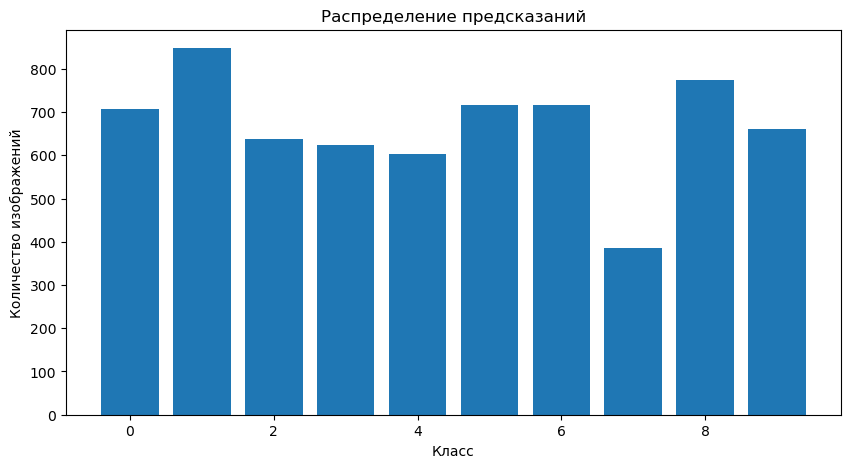

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

# Подсчет частоты классов
class_counts = Counter(test_predictions)
print("Распределение предсказанных классов:")
for cls, count in sorted(class_counts.items()):
    print(f"Класс {cls}: {count} изображений ({count/len(test_predictions):.1%})")

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Класс')
plt.ylabel('Количество изображений')
plt.title('Распределение предсказаний')
plt.show()

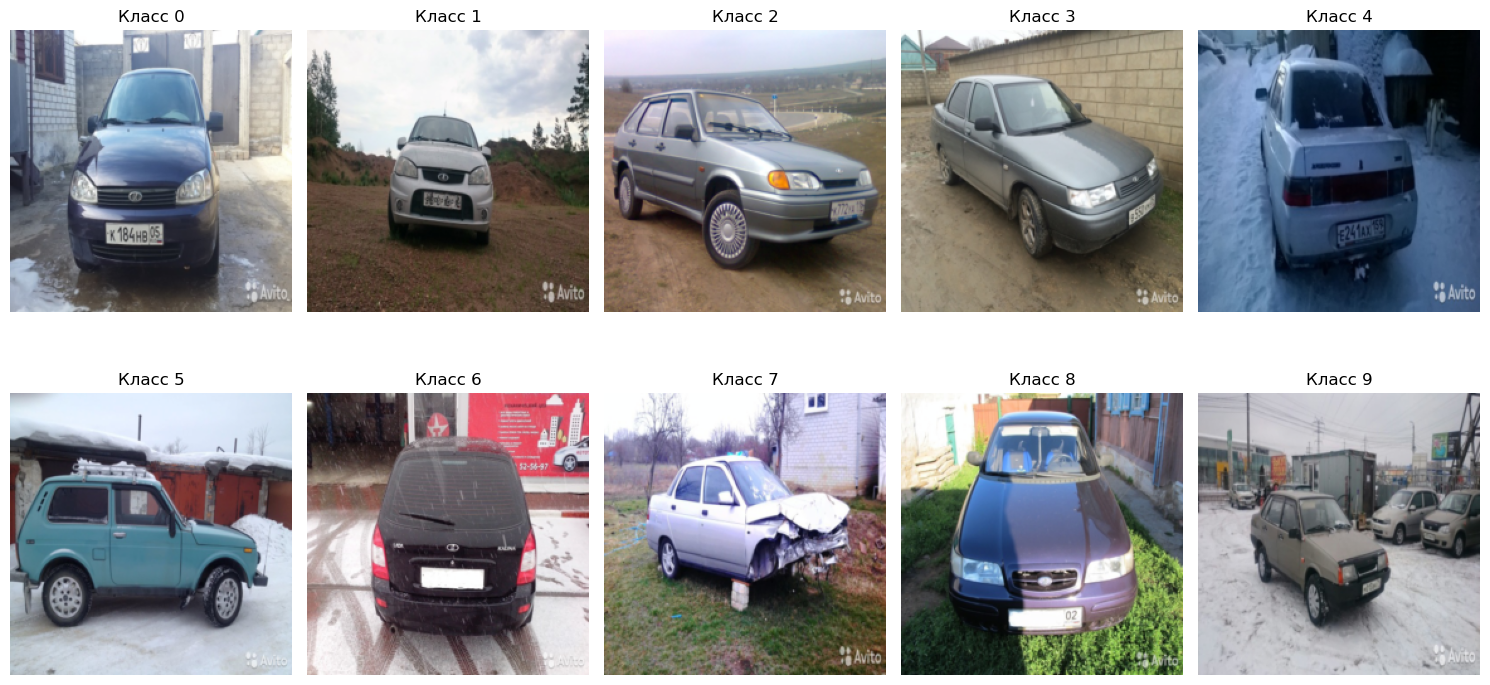

In [14]:
# Покажем по 1 примеру для каждого предсказанного класса
unique_classes = set(test_predictions)
plt.figure(figsize=(15, 8))
for i, cls in enumerate(sorted(unique_classes)):
    # Найдем первый пример этого класса
    idx = test_predictions.index(cls)
    img, _ = test_dataset[idx]
    
    # Денормализация для отображения
    img = img.numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f'Класс {cls}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
if 'class_names' in saved_state:
    with open('predictions_with_names.txt', 'w') as f:
        for pred in test_predictions:
            class_name = saved_state['class_names'][pred]
            f.write(f"{pred} ({class_name})\n")
    print("Предсказания с именами классов сохранены")

Предсказания с именами классов сохранены
